In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from collections import Counter
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
# Specify the path to the CSV file
file_path_train = "data/train.csv"
file_path_test = "data/train.csv"


# Read the CSV file into a DataFrame
df = pd.read_csv(file_path_train, delimiter=",", parse_dates=['host_since', 'first_review', 'last_review'])
df_test = pd.read_csv(file_path_test, delimiter=",", parse_dates=['host_since', 'first_review', 'last_review'])

# Drop the original price column and separate features and target
y = df['price']
X = df.drop(columns=['price'])
y_test = df_test['price']
X_test = df_test.drop(columns=['price'])


In [2]:
# all_amenities = [item for sublist in df['amenities'].to_numpy() for item in sublist]
    
#     # Count occurrences of each amenity
# amenity_counts = Counter(all_amenities)
# len(amenity_counts)

In [3]:
def get_top_amenities(list_of_lists,n=10):
    # Flatten the list of lists
    all_amenities = [item for sublist in list_of_lists for item in sublist]
    
    # Count occurrences of each amenity
    amenity_counts = Counter(all_amenities)
    
    # Get the top 10 most common amenities
    top_n_amenities = amenity_counts.most_common(n)
    
    # Extract just the amenity names
    top_amenity_names = [amenity for amenity,count in top_n_amenities]
    
    # Calculate the total number of amenities for each row
    total_amenities_per_row = [len(sublist) for sublist in list_of_lists]
    
    return top_amenity_names, total_amenities_per_row

# Convert the 'amenities' column from string format to a Python list
df['amenities'] = df['amenities'].str.replace('[', '').str.replace(']', '').str.replace('"', '').str.split(', ')
# Get top 10 amenities
#top_10_amenities = get_top_10_amenities(df['amenities'].to_numpy())
top_amenities,total_amenities_per_row = get_top_amenities(df['amenities'].to_numpy(),3000)

datetime_columns = ['host_since', 'first_review', 'last_review']
# Ensure the columns are in datetime format
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate the numeric representation for each column
for col in datetime_columns:
    # Find the minimum date for this column
    min_date = df[col].min()
    # Calculate the difference in days
    df[f'{col}_numeric'] = (df[col] - min_date).dt.days
    # Replace NaT with NaN in the numeric column
    df[f'{col}_numeric'] = df[f'{col}_numeric'].replace({pd.NaT: np.nan})



In [5]:
print(df.index)

RangeIndex(start=0, stop=15696, step=1)


In [6]:
# Print the type and first row value of each column
for col in df.columns:
    print(f"{col} (Type: {df[col].dtype}): {df[col].iloc[0]}")

name (Type: object): Bed-Stuy 2 Bed/2 Bath - Renovated
description (Type: object): Welcome to Bed-Stuy, Brooklyn! Our newly renovated brownstone has an apartment that is colorful and comfortable and entirely yours during your stay. Bed-Stuy is a friendly neighborhood with tree-lined streets and rows upon rows of traditional brownstones. We are close to many restaurants and coffee shops as well as perfectly located for exploring Brooklyn. Relax on the patio or take a quick trip into that other borough (Manhattan). We are a 5 minute walk to the Kingston/Throop C subway.
property_type (Type: object): Entire rental unit
price (Type: int64): 4
neighbourhood_cleansed (Type: object): Bedford-Stuyvesant
neighbourhood_group_cleansed (Type: object): Brooklyn
latitude (Type: float64): 40.68456
longitude (Type: float64): -73.93987
host_since (Type: datetime64[ns]): 2015-05-23 00:00:00
host_response_time (Type: object): within a day
host_response_rate (Type: float64): 100.0
host_acceptance_rate (Ty

In [7]:
# Separate numeric and other columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
other_cols = X.select_dtypes(include=['object']).columns
X_clean = X.copy()

# Create one-hot encoded columns for the top amenities in a vectorized way
amenities_df = pd.DataFrame(
    {f'has_{amenity.lower().replace(" ", "_")}': X_clean['amenities'].apply(lambda x: int(amenity in x)) 
     for amenity in top_amenities}
)

# Concatenate the new columns with the original DataFrame
X_clean = pd.concat([X_clean, amenities_df], axis=1)
    
X_clean = X_clean.drop(columns=["name","description","reviews","amenities","bathrooms_text",'host_since', 'first_review', 'last_review'])

# make new row for total_amenities
X_clean['total_amenities'] = total_amenities_per_row


#might remove neighbourhood_cleansed as it has a lot
cat_columns = ['property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', "host_verifications","host_response_time","room_type"]
X_clean[cat_columns] = X_clean[cat_columns].astype('category')

#fix boolean data
X_clean['host_is_superhost'] = X_clean['host_is_superhost'].fillna(False).astype(bool)
X_clean['has_availability'] = X_clean['has_availability'].fillna(False).astype(bool)


# Scale only the numeric columns
# scaler = StandardScaler()
# X_clean[numeric_cols] = scaler.fit_transform(X_clean[numeric_cols])

# One-hot encode categorical columns
#X_clean = pd.get_dummies(X_clean, columns=cat_columns, drop_first=True)

# converting a categorical column to integer labels
for col in cat_columns:  # replace with your actual categorical columns
    X_clean[col] = LabelEncoder().fit_transform(X_clean[col])
categorical_features = [X_clean.columns.get_loc(col) for col in cat_columns]

# Function to clean column names
def clean_column_name(col_name):
    return col_name.replace('[', '').replace(']', '').replace('<', '')
# Apply the cleaning function to all column names
X_clean.columns = X_clean.columns.map(clean_column_name)


# #make reviews vecs
# df["reviews"] = df["reviews"].fillna("")
# vectorizer = TfidfVectorizer()
# # Transform the 'reviews' column into numerical features
# X_reviews_tfidf = vectorizer.fit_transform(df["reviews"])

# X_clean = csr_matrix(X_clean, dtype='float64')
# # 6. Combine the TF-IDF features with the non-text (encoded) features
# # Example weighting factor
# weight_factor = 3.0
# # Apply weight to X_clean
# X_clean_weighted = X_clean * weight_factor
# X_clean = hstack([X_reviews_tfidf, X_clean_weighted])

# Display the cleaned column names
#print(X_clean.columns)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.2, random_state=42)

/tmp/ipykernel_28592/1921189325.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_clean['host_is_superhost'] = X_clean['host_is_superhost'].fillna(False).astype(bool)
/tmp/ipykernel_28592/1921189325.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_clean['has_availability'] = X_clean['has_availability'].fillna(False).astype(bool)


In [8]:
# len(X_clean.columns)
# for col in X_clean.columns:
#     print(f"{col} (Type: {X_clean[col].dtype}): {X_clean[col].iloc[0]}")

In [9]:
unique_categories = df['host_identity_verified'].unique()
# Verify the result
print(len(unique_categories))
print(unique_categories)

2
[ True False]


In [10]:
# object_columns = X_clean.select_dtypes(include=['object']).columns
# print("Columns of type 'object' in X_clean:")
# for col in object_columns:
#     print(col)
# object_columns = X_clean.select_dtypes(include=['datetime']).columns
# print("Columns of type 'time' in X_clean:")
# for col in object_columns:
#     print(col)


0.8070154182853748

In [11]:

# # Initialize and train HistGradientBoostingClassifier or HistGradientBoostingRegressor
# model = HistGradientBoostingClassifier(categorical_features=categorical_features, random_state=42)
# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.01],
#     'max_iter': [200],
#     'max_depth': [9],
#     'l2_regularization': [0.1, 0.2],
#     'min_samples_leaf': [3]
# }
# # Set up the grid search
# grid_search = GridSearchCV(model, param_grid, cv=5,verbose=3, n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Best parameters
# print(grid_search.best_params_)
# # Use the best model from the grid search to make predictions
# best_model = grid_search.best_estimator_
# #y_pred = np.round(best_model.predict(X_val))
# y_pred = (best_model.predict(X_val))

# # Evaluate the model
# accuracy = accuracy_score(y_val, y_pred)
# conf_matrix = confusion_matrix(y_val, y_pred)
# class_report = classification_report(y_val, y_pred)


# # Calculate RMSE by treating the quantile labels as numeric values
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print("Root Mean Squared Error on validation set:", rmse)

# print("Accuracy on validation set:", accuracy)
# print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", class_report)


0.9132778509966281

In [12]:

# # Initialize and train HistGradientBoostingClassifier
# # Define the parameter grid
# params = {'l2_regularization': 0.2,'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 100, 'min_samples_leaf': 5}

# model = HistGradientBoostingClassifier(categorical_features=categorical_features, random_state=42, **params)

# # Fit the model
# model.fit(X_train, y_train)

# #y_pred = np.round(best_model.predict(X_val))
# y_pred = (model.predict(X_val))

# # Evaluate the model
# accuracy = accuracy_score(y_val, y_pred)
# conf_matrix = confusion_matrix(y_val, y_pred)
# class_report = classification_report(y_val, y_pred)


# # Calculate RMSE by treating the quantile labels as numeric values
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print("Root Mean Squared Error on validation set:", rmse)

# print("Accuracy on validation set:", accuracy)
# print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", class_report)


0.75354787167402880.

In [48]:

# Define the model with custom parameters
params = {
    'learning_rate': 0.01,
    'max_depth': 9,
    'min_child_weight': 3,
    'reg_lambda': 1.0,
    'reg_alpha': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',  # For regression
    'eval_metric': 'rmse',            # RMSE as evaluation metric
    'random_state': 1  # Set the seed here
}

# Initialize the XGBRegressor with the specified parameters
model = xgb.XGBRegressor(**params)

#model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse")

# Initialize and train XGBClassifier model
model.fit(X_train, y_train)

# Predictions on validation set
y_pred = y_pred_bounded = np.clip(np.round(model.predict(X_val)), 0, 5)

# Calculate accuracy and RMSE on validation set
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on validation set:", accuracy)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Root Mean Squared Error on validation set:", rmse)

# Predictions on training set
y_pred_train = np.clip(np.round(model.predict(X_train)), 0, 5)

# Calculate accuracy and RMSE on training set
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {train_accuracy:.4f}")

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Root Mean Squared Error on training set:", train_rmse)

# Classification report on validation set
print("\nClassification Report on validation set:")
print(classification_report(y_val, y_pred))

# Feature importance (sorted)
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Important Features:")
for feature, score in sorted_importance[:10]:  # Display top 10 features
    print(f"{feature}: {score}")


Accuracy on validation set: 0.6101910828025477
Root Mean Squared Error on validation set: 0.7573419828458553
Accuracy on training set: 0.8831
Root Mean Squared Error on training set: 0.3485052046498691

Classification Report on validation set:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       540
           1       0.58      0.54      0.56       524
           2       0.46      0.57      0.51       513
           3       0.50      0.63      0.56       556
           4       0.50      0.49      0.50       463
           5       0.89      0.68      0.77       544

    accuracy                           0.61      3140
   macro avg       0.64      0.61      0.62      3140
weighted avg       0.64      0.61      0.62      3140


Top 10 Important Features:
latitude: 11431.0
longitude: 10715.0
availability_365: 6941.0
host_acceptance_rate: 6776.0
neighbourhood_cleansed: 6624.0
reviews_per_month: 5509.0
total_amenities: 5382.0
number_of_rev

In [14]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report

# Define the model parameters
params = {
    'learning_rate': 0.01,
    'max_depth': 9,
    'min_child_weight': 3,
    'reg_lambda': 1.0,
    'reg_alpha': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'eval_metric' : ['rmse', 'mae'],
    'tree_method': 'hist',
    'device': 'cuda',
    'random_state': 1  # Set the seed here

}
# Initialize the XGBRegressor with the specified parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Predictions on validation set
y_pred = np.clip(np.round(model.predict(X_val)), 0, 5)

# Calculate accuracy and RMSE on validation set
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error on validation set: {rmse:.4f}")

# Predictions on training set
y_pred_train = np.clip(np.round(model.predict(X_train)), 0, 5)

# Calculate accuracy and RMSE on training set
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {train_accuracy:.4f}")

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Root Mean Squared Error on training set: {train_rmse:.4f}")

# Classification report on validation set
print("\nClassification Report on validation set:")
print(classification_report(y_val, y_pred))

# Feature importance (sorted)
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Important Features:")
for feature, score in sorted_importance[:10]:
    print(f"{feature}: {score}")


/usr/local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:48:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy on validation set: 0.6162
Root Mean Squared Error on validation set: 0.7489
Accuracy on training set: 0.8832
Root Mean Squared Error on training set: 0.3484

Classification Report on validation set:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       540
           1       0.59      0.55      0.57       524
           2       0.47      0.58      0.52       513
           3       0.49      0.62      0.55       556
           4       0.51      0.50      0.50       463
           5       0.90      0.69      0.78       544

    accuracy                           0.62      3140
   macro avg       0.64      0.61      0.62      3140
weighted avg       0.65      0.62      0.63      3140


Top 10 Important Features:
longitude: 10893.0
latitude: 10787.0
availability_365: 6994.0
neighbourhood_cleansed: 6896.0
host_acceptance_rate: 6802.0
total_amenities: 5647.0
reviews_per_month: 5449.0
number_of_reviews: 4324.0
review_scores_location:

In [15]:
# import xgboost as xgb
# from xgboost import XGBClassifier
# from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
# import numpy as np

# # Define parameter dictionary for XGBClassifier
# params = {
#     'objective': 'multi:softmax',
#     'learning_rate': 0.01,
#     'max_depth': 9,
#     'min_child_weight': 3,
#     'reg_lambda': 1.0,
#     'reg_alpha': 0.1,
#     'n_estimators': 1000,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'num_class': len(np.unique(y_train)),
#     'objective': 'reg:squarederror',  # For regression
#     'eval_metric': 'rmse'            # RMSE as evaluation metric
# }

# # Initialize and train XGBClassifier model
# model = XGBClassifier(**params, random_state=42)
# model.fit(X_train, y_train)

# # Predictions on validation set
# y_pred = model.predict(X_val)

# # Calculate accuracy and RMSE on validation set
# accuracy = accuracy_score(y_val, y_pred)
# print("Accuracy on validation set:", accuracy)

# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print("Root Mean Squared Error on validation set:", rmse)

# # Predictions on training set
# y_pred_train = model.predict(X_train)

# # Calculate accuracy and RMSE on training set
# train_accuracy = accuracy_score(y_train, y_pred_train)
# print(f"Accuracy on training set: {train_accuracy:.4f}")

# train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
# print("Root Mean Squared Error on training set:", train_rmse)

# # Classification report on validation set
# print("\nClassification Report on validation set:")
# print(classification_report(y_val, y_pred))

# # Feature importance (sorted)
# importance = model.get_booster().get_score(importance_type='weight')
# sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
# print("\nTop 10 Important Features:")
# for feature, score in sorted_importance[:10]:  # Display top 10 features
#     print(f"{feature}: {score}")


Accuracy test: 0.6162


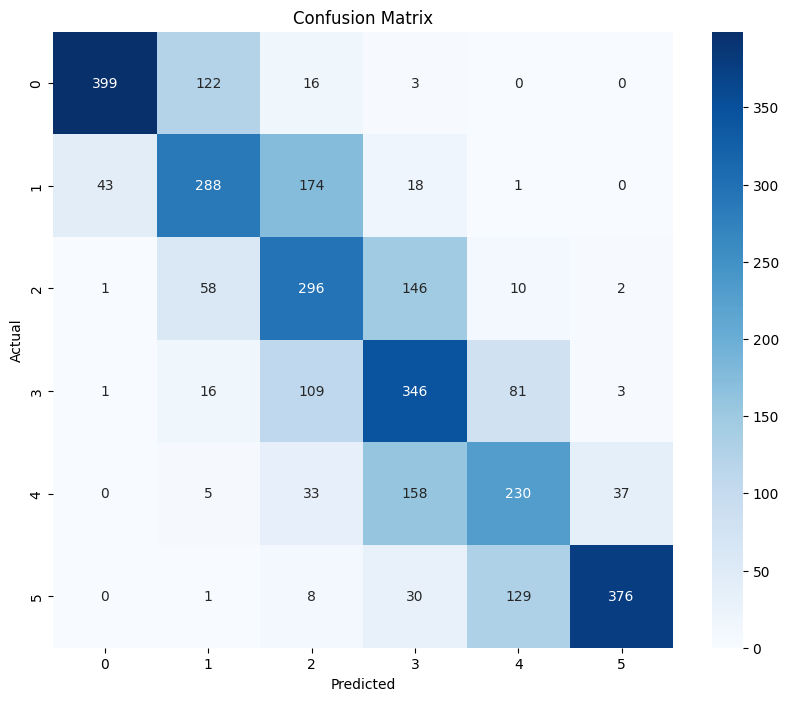

In [16]:
# Evaluate the model

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy test: {accuracy:.4f}")
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
# # Define the parameter dictionary for XGBClassifier
# params = {
#     'learning_rate': 0.1,
#     'n_estimators': 150,  # Equivalent to the number of boosting rounds
#     'max_depth': 9,
#     'reg_lambda': 0.1,     # L2 regularization parameter
# }

# # Initialize the model with the parameters
# model = XGBClassifier(**params, random_state=42)

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions on the validation set
# y_pred = model.predict(X_val)

# # Evaluate the model using accuracy
# accuracy = accuracy_score(y_val, y_pred)
# print("Accuracy on validation set:", accuracy)

# # Calculate RMSE between predicted and true quantile classes
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print("Root Mean Squared Error on validation set:", rmse)


Accuracy on validation set: 0.6334394904458599
Root Mean Squared Error on validation set: 0.8423503666096361


# best so far
0.7577623780949084
# Define the model with custom parameters
params = {
    'learning_rate': 0.01,
    'max_depth': 9,
    'min_child_weight': 3,
    'reg_lambda': 1.0,
    'reg_alpha': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',  # For regression
    'eval_metric': 'rmse'            # RMSE as evaluation metric
}

# Initialize the XGBRegressor with the specified parameters
model = xgb.XGBRegressor(**params)

In [18]:
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb
# import numpy as np

# # Define the base model
# model = xgb.XGBRegressor(
#     reg_lambda=1.0,
#     reg_alpha=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective='reg:squarederror',
#     eval_metric='rmse',
#     random_state=1
# )

# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'max_depth': [3, 6, 9],
#     'min_child_weight': [1, 3, 5],
#     'n_estimators': [100, 500, 1000]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,  # Use all available cores
#     verbose=2
# )

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = np.sqrt(-grid_search.best_score_)  # Convert MSE to RMSE

# print("Best parameters:", best_params)
# print("Best RMSE:", best_score)

# # Use the best model for predictions
# best_model = grid_search.best_estimator_
# y_pred = np.clip(np.round(best_model.predict(X_val)), 0, 5)
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb
# import numpy as np

# # Define the base model
# model = xgb.XGBRegressor(
#     reg_lambda=1.0,
#     reg_alpha=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective='reg:squarederror',
#     eval_metric='rmse',
#     random_state=1
# )

# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'max_depth': [3, 6, 9],
#     'min_child_weight': [1, 3, 5],
#     'n_estimators': [100, 500, 1000]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,  # Use all available cores
#     verbose=2
# )

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = np.sqrt(-grid_search.best_score_)  # Convert MSE to RMSE

# print("Best parameters:", best_params)
# print("Best RMSE:", best_score)

# # Use the best model for predictions
# best_model = grid_search.best_estimator_
# y_pred = np.clip(np.round(best_model.predict(X_val)), 0, 5)


In [29]:
# First XGBoost model
params1 = {
    'learning_rate': 0.01,
    'max_depth': 9,
    'min_child_weight': 3,
    'reg_lambda': 1.0,
    'reg_alpha': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse', 'mae'],
    'tree_method': 'hist',
    'device': 'cuda',
    'random_state': 1
}

model1 = xgb.XGBRegressor(**params1)

# Train the first model
model1.fit(X_train, y_train)

# Get predictions from the first model
X_train_pred = model1.predict(X_train).reshape(-1, 1)
X_val_pred = model1.predict(X_val).reshape(-1, 1)

# Ensure amenities_df is a list of column names
selected_columns = list(amenities_df.columns)  # Replace with actual column names if needed
X_train2 = X_train[selected_columns]    
X_val2 = X_val[selected_columns]    
# Combine the predictions with extra training data
X_train_combined = np.hstack((X_train2, X_train_pred))
X_val_combined = np.hstack((X_val2, X_val_pred))


In [45]:
# Second XGBoost model
params2 = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 75,
    'reg_lambda': 0.8,
    'reg_alpha': 0.2,
    'n_estimators': 800,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse', 'mae'],
    'random_state': 2
}

# Create the second XGBoost model without scaling
model2 = xgb.XGBRegressor(**params2)

# Train the second model
model2.fit(X_train_combined, y_train)

# Make predictions using the second model
y_pred = np.clip(np.round(model2.predict(X_val_combined)), 0, 5)

# Calculate accuracy and RMSE on validation set
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error on validation set: {rmse:.4f}")

# Predictions on training set
y_pred_train = np.clip(np.round(model2.predict(X_train_combined)), 0, 5)

# Calculate accuracy and RMSE on training set
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {train_accuracy:.4f}")

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Root Mean Squared Error on training set: {train_rmse:.4f}")

# Classification report on validation set
print("\nClassification Report on validation set:")
print(classification_report(y_val, y_pred))

# Feature importance (sorted) for the second model
importance = model2.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Important Features:")
for feature, score in sorted_importance[:10]:
    print(f"{feature}: {score}")

Accuracy on validation set: 0.6258
Root Mean Squared Error on validation set: 0.7444
Accuracy on training set: 0.9329
Root Mean Squared Error on training set: 0.2626

Classification Report on validation set:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       540
           1       0.59      0.59      0.59       524
           2       0.48      0.53      0.50       513
           3       0.50      0.59      0.54       556
           4       0.50      0.50      0.50       463
           5       0.87      0.74      0.80       544

    accuracy                           0.63      3140
   macro avg       0.64      0.62      0.63      3140
weighted avg       0.64      0.63      0.63      3140


Top 10 Important Features:
f2909: 3390.0
f48: 267.0
f24: 211.0
f15: 205.0
f19: 204.0
f7: 200.0
f11: 192.0
f23: 192.0
f40: 183.0
f21: 176.0
